In [1]:
# !pip install -q shap
# !pip install -q eli5
# !pip install -q xgboost

## Modelling
I have built a baseline model using random forest and used this model to do other evaluations such as, 

- finding important features affecting the model results, 
- understanding the meaning of those features using SHAP values, 
- finding the partial dependence of these feature on the loan_status. 
- (Here due to some reason, I couldn't get permutation importance of each feature with loan_status). 

After building a base line model, I saw skewness in the precision recall curve, thus, I created Support Vector Classifer giving class weights. Again due to some reason, it was taking longer than need, thus, I built a SVM in Neural Network using Keras, and it gave result as predicted.

To further improve the baseline model, I used ensemble model wherein I used Random Forest and Xgboost on soft Voting Classifier and used Linear regression to find the meta feature to stack all the three. The results obtained for stacked ensemble model were better than baseline model.  

Grid Search (code not included) and https://arxiv.org/pdf/1708.05070.pdf is used find the best model and parameters for each of the listed models. 

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import shap
import eli5
from eli5.sklearn import PermutationImportance
import xgboost as xgb

from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import plot_partial_dependence

from sklearn.metrics import accuracy_score, precision_recall_curve, roc_auc_score, roc_curve, f1_score, auc


After importing the packges, load the cleaned CSV, convert dtype of all the columns to integer values and remove NA if any.

In [46]:
df = pd.read_csv('data/stage2_loans.csv')
for col in df.columns.tolist():
    df[col] = df[col].astype(np.int64)
df = df.dropna()

Create a test train split, but before that, separate records where category is 'Ongoing' and 'Late', set these records for prediction and then split these records into test and train, ratio 30:70.

In [56]:
x_y_test = df[df.loan_status == 2] #  'Ongoing' and 'Late'
x_y_test = x_y_test.drop(['loan_status'], 1).values
x_y_train = df[df.loan_status != 2] # CHraged off, default and paid

y = x_y_train['loan_status'].values
x = x_y_train.drop(['loan_status'], 1).values

feature_names = x_y_train.drop(['loan_status'], 1).columns
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=1, stratify=y)

### Build random-forest classifier - Baseline Model
We are using scoring metric as 'roc_auc' and not 'accuracy' as accuracy scores tends to over estimate the results in senarios like fraud detection, as there are lot of true negative cases. 

In [49]:
rnd_fr_clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.25,
                                criterion="entropy",
                                class_weight="balanced",
                                random_state=1)

scores = cross_val_score(rnd_fr_clf,
                         x_train, 
                         y_train,
                         scoring="roc_auc", 
                         cv=10, 
                         n_jobs=-1, 
                         verbose=50)
print("Baseline model (RandomForest) Mean AUC:", scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:  4.2min remaining: 16.6min
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  4.2min remaining:  9.7min
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:  4.2min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  4.2min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  4.2min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  4.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  4.2min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.3min finished
Baseline model (RandomForest) Mean AUC: 0.6919701392208555


#### Results
As seen, the baseline model recorded a mean auc of around 69%. Below we plot the ROC curve and Precsion Recall (PR) Curve to better understand the results.
As seen in the PR Curve, the graph is skewed, this is because, data is highly imbalanced towards fully paid loans. We would build SVC and apply class weights to imporve the results.

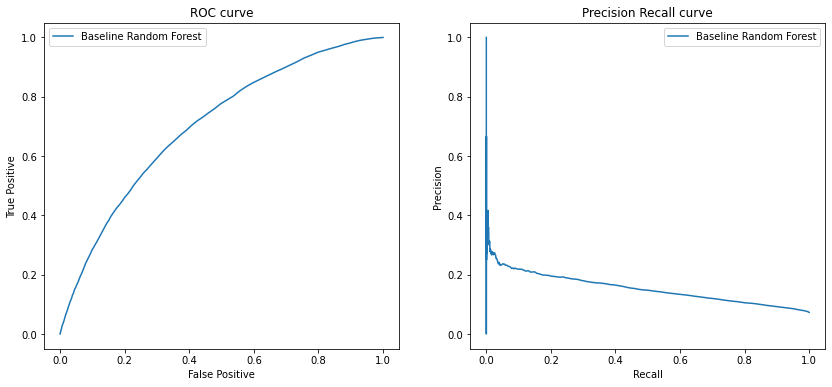

In [50]:
# train_acc = rnd_fr_clf.score(x_train, y_train)
# y_pred = rnd_fr_clf.predict(x_test)
# test_acc = accuracy_score(y_test, y_pred)
# print(train_acc,test_acc)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

rnd_fr_clf.fit(x_train, y_train)
# predict probabilities
probs = rnd_fr_clf.predict_proba(x_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
# y_pred = rnd_fr_clf.predict(x_test)

# plot the ROC curve
rnd_fr_fpr, rnd_fr_tpr, rnd_fr_th = roc_curve(y_test, probs)
ax[0].plot(rnd_fr_fpr, rnd_fr_tpr, label='Baseline Random Forest')
ax[0].set_xlabel("False Positive")
ax[0].set_ylabel("True Positive")
ax[0].legend()
ax[0].set_title("ROC curve")
# plot the precision-recall curve
rnd_fr_precision, rnd_fr_recall, _ = precision_recall_curve(y_test, probs)
ax[1].plot(rnd_fr_recall, rnd_fr_precision, label='Baseline Random Forest')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].legend()
ax[1].set_title("Precision Recall curve")
plt.show()

Below we build feature importance graph, to try an understand which features impacted the most and which the least. And we find that Installment and credit card balance where the few important features. 

Text(0.5, 1.0, 'Feature Importance')

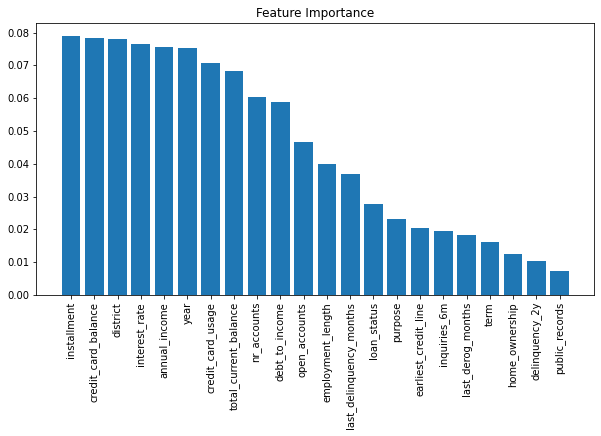

In [51]:
fr_importance = rnd_fr_clf.feature_importances_
ind = np.argsort(rnd_fr_clf.feature_importances_)[::-1]
plt.figure(figsize=(10, 5))
plt.bar(range(1, 23), fr_importance[ind], align="center")
plt.xticks(range(1, 23), df.columns[ind], rotation=90)
plt.title("Feature Importance")

After finding the important feature, we try and project these on 'Late' and 'Ongoing' dataset to build a partial dependence graph of six most important features.

- installment
- credit_card_balance
- interest_rate
- annual_income
- total_current_balance
- nr_accounts

We can infer from the following graph that our projections are correct. 

- installment, if the installment are high, loan is less likly be paid
- credit_card_balance, if the credit_card_balance is high,  loan is less likly be paid
- interest_rate, if the interest_rate is high, loan is less likly be paid
- annual_income, if the annual_income is loan, loan is less likly be paid
- total_current_balance, if the total_current_balance is loan, loan is less likly be paid
- nr_accounts, if the nr_accounts is high, loan is less likly be paid

Text(0.5, 0.98, 'Partial dependence of loan status on important features')

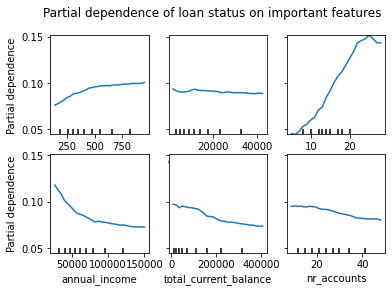

In [66]:
target_features = [0,16,1,5,17,18]
plot_partial_dependence(rnd_fr_clf, x_y_test, target_features,
                                    feature_names=feature_names.tolist(), n_jobs=-1,
                                    grid_resolution=30)


fig = plt.gcf()
fig.suptitle('Partial dependence of loan status on important features')

Below we plot SHAP values for a record who default on loan, and most important feature due to which the predictions are true (default) is "Interest rate" and other features are annual income etc.

In [8]:
row_id = 6

d_val = x_y_train.drop(['loan_status'], 1).iloc[row_id]  
d_val_arr = d_val.values.reshape(1, -1)
rnd_fr_clf.predict_proba(d_val_arr)
explainer = shap.TreeExplainer(rnd_fr_clf)
shap_values = explainer.shap_values(d_val_arr)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], d_val)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [9]:
# my_model = RandomForestClassifier(n_estimators=100, random_state=0).fit(x_train, y_train)

# perm = PermutationImportance(my_model, random_state=1).fit(x_test, y_test)
# eli5.show_weights(perm, feature_names = feature_names.tolist())

### Improving Baseline - Classwise - Balanced Model
Class weights can be calculated and be substituted and model can be built on top on class weights, this has been done below. Although the accuracy of the model decreased 58%, which is common, but PR and AUC also decreased. 

In [10]:
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
d_class_weights = dict(enumerate(class_weights))
# svm_clf = SVC(gamma=0.1,
#               C=0.01,
#               kernel="poly",
#               degree=3,
#               coef0=10.0,
#               probability=True,
#               random_state=1,
#               class_weight='balanced')
# scores = cross_val_score(svm_clf,
#                          x_train, 
#                          y_train,
#                          scoring="roc_auc", 
#                          cv=10, 
#                          n_jobs=-1, 
#                          verbose=50)
# print("Balanced model (SVM) Mean AUC:", scores.mean())

In [32]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2

model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(1, kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='linear'))
model.compile(loss='hinge',
              optimizer='adadelta',
              metrics=['accuracy'])
model.fit(x_train, 
          y_train,
          class_weight=d_class_weights,
          validation_split=0.2,
          epochs=1)

Train on 124508 samples, validate on 31127 samples
Epoch 1/1
124508/124508 [==============================] - 9s 72us/step - loss: 6.8710 - accuracy: 0.5807 - val_loss: 1.0061 - val_accuracy: 0.8428


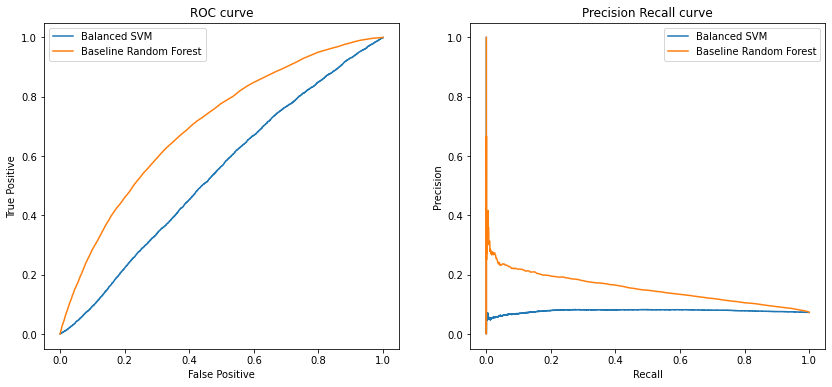

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# svm_clf.fit(x_train, y_train)
# probs = svm_clf.predict_proba(x_test)
# probs = probs[:, 1]
y_pred = model.predict(x_test)

# plot the ROC curve
svm_fpr, svm_tpr, svm_th = roc_curve(y_test, y_pred)
ax[0].plot(svm_fpr, svm_tpr, label='Balanced SVM')
ax[0].plot(rnd_fr_fpr, rnd_fr_tpr, label='Baseline Random Forest')
ax[0].set_xlabel("False Positive")
ax[0].set_ylabel("True Positive")
ax[0].legend()
ax[0].set_title("ROC curve")
# plot the precision-recall curve
svm_precision, svm_recall, _ = precision_recall_curve(y_test, y_pred)
ax[1].plot(svm_recall, svm_precision, label='Balanced SVM')
ax[1].plot(rnd_fr_recall, rnd_fr_precision, label='Baseline Random Forest')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].legend()
ax[1].set_title("Precision Recall curve")
plt.show()

### Improving Baseline Model - Ensemble Model

Here we would use ensemble modelling technique to build a stong classifier which is based on (weak) classifiers.
For this consideration, I have chosen Random Forest and Xgboost classifer, and combined these into single classifier based on soft voting mechanism - average classifer. 

Then I have used the above average classifer to calculate the meta features, which are given into logistic regression classifier to predict the result, thus I have stacked all the three models here.

In [34]:
# Define base learners
rnd_fr_clf = RandomForestClassifier(n_estimators=300,
                                max_features="sqrt",
                                criterion="gini",
                                min_samples_leaf=5,
                                class_weight="balanced",
                                random_state=1)

xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
                            learning_rate=0.03,
                            n_estimators=500,
                            max_depth=1,
                            subsample=0.4,
                            random_state=1)

# Define meta-learner
logreg_clf = LogisticRegression(penalty="l2",
                                C=100,
                                fit_intercept=True)

# average ensemble
voting_clf = VotingClassifier([("xgb", xgb_clf),
                               ("rf", rnd_fr_clf)],
                              voting="soft",
                              flatten_transform=True)
voting_clf.fit(x_train, y_train)
xgb_model, rf_model = voting_clf.estimators_

In [35]:
models = {"xgb": xgb_model, "rf": rf_model, "avg_ensemble": voting_clf}

Below, generating meta features, which will be used in the logistic regression. 

In [36]:
# Build first stack of base learners
average_ensemble = make_pipeline(voting_clf,
                            FunctionTransformer(lambda X: X[:, 1::2]))
# Use CV to generate meta-features
meta_features = cross_val_predict(average_ensemble,
                                  x_train, 
                                  y_train,
                                  cv=10,
                                  method="transform",
                                  n_jobs=-1,
                                  verbose=50)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:  1.9min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.9min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:  1.9min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.9min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.9min remaining:   49.7s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  1.9min remaining:   29.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.0min finished


In [37]:
# Refit the first stack on the full training set
average_ensemble.fit(x_train, y_train)
# Fit the meta learner
stacked_ensemble = logreg_clf.fit(meta_features, y_train)

Below we see the ROC and PR curves. Although the PR curve is still skewed but, we can understand with the values of AUC that stacked ensemble and average ensemble have imporved over the baseline model.  

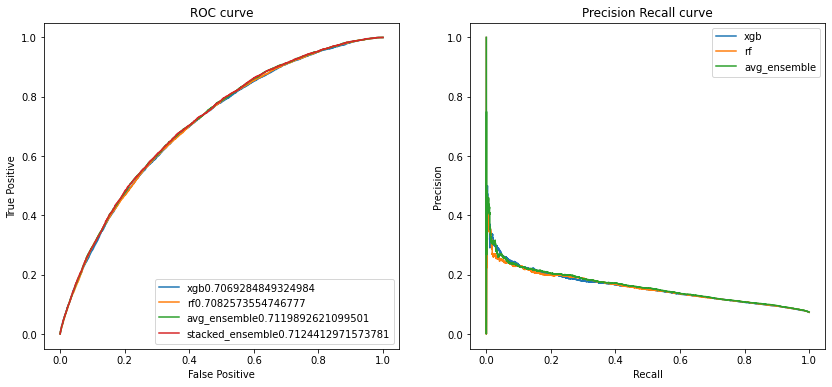

In [39]:
# Plot ROC and PR curves using all models and test data
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for name, model in models.items():
    model_probs = model.predict_proba(x_test)[:, 1:]
    model_auc_score = roc_auc_score(y_test, model_probs)
    fpr, tpr, th = roc_curve(y_test, model_probs)
    precision, recall, _ = precision_recall_curve(y_test, model_probs)
    ax[0].plot(fpr, tpr, label=name + str(model_auc_score))
    ax[1].plot(recall, precision, label=name)

stacked_probs = stacked_ensemble.predict_proba(average_ensemble.transform(x_test))[:, 1:]
stacked_auc_score = roc_auc_score(y_test, stacked_probs)
fpr, tpr, th = roc_curve(y_test, stacked_probs)
ax[0].plot(fpr, tpr, label="stacked_ensemble"+ str(stacked_auc_score))
ax[0].set_xlabel("False Positive")
ax[0].set_ylabel("True Positive")
ax[0].legend()
ax[0].set_title("ROC curve")
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].legend()
ax[1].set_title("Precision Recall curve")
plt.show()